In [1]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
labels = pd.read_csv('y_train.csv', index_col='id')
data = pd.read_csv('X_train.csv', index_col='id')

In [3]:
labels.head()

,y
id,
0,0
1,0
2,0
3,1
4,2


In [4]:
# Retrieve one sample recording per class for plotting
labels_array = labels['y'].to_numpy()
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[15]))
    
# Print indices of the sample signals
sample_signal_ids

[31, 144, 48, 501]

In [6]:
# Show the data
data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806
id,,,,,,,,,,,,,,,,,,,,,
0,-13,-9,-6,-4,0,2,6,12,23,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-34,110,249,390,527,639,721,777,823,845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-34,-36,-37,-39,-41,-42,-44,-46,-48,-51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,292,298,303,310,320,336,354,377,405,419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,157,179,195,210,217,222,226,228,231,233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-247,-271,-285,-303,-334,-376,-413,-432,-443,-451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,62,62,61,61,61,61,61,61,61,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,-95,-110,-124,-131,-126,-114,-95,-67,-42,-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.max()

x0        4953.0
x1        5133.0
x2        5297.0
x3        5392.0
x4        5403.0
           ...  
x17802     205.0
x17803     203.0
x17804     200.0
x17805     198.0
x17806     197.0
Length: 17807, dtype: float64

In [8]:
data.min()

x0       -5185.0
x1       -4589.0
x2       -4442.0
x3       -4431.0
x4       -4423.0
           ...  
x17802     205.0
x17803     203.0
x17804     200.0
x17805     198.0
x17806     197.0
Length: 17807, dtype: float64

### Pay attention to NaN values! 

Unlike many medical application, these NaNs **DO NOT** represent missing values but appear because of variable length of the signals. ECG recordings normally don't have missing values and are sampled equally.

Despite being put into a tabular CSV format / Pandas Dataframe, the data is still a raw signal with variable lengths. Coumns *x0, ..., x17806* correspond to measurements at time stamps *0, ..., 17806* and not to different features of the data point. If the signal is too short then all the coumns after the last measurement have NaN values,

In [9]:
# Get the raw recording without Nan values as a NumPy array
data.loc[0].dropna().to_numpy(dtype='float32')

array([-13.,  -9.,  -6., ...,  60.,  74.,  91.], dtype=float32)

In [10]:
data.loc[0].dropna().to_numpy(dtype='float32').shape

(16322,)

## Plot sample signals for each class

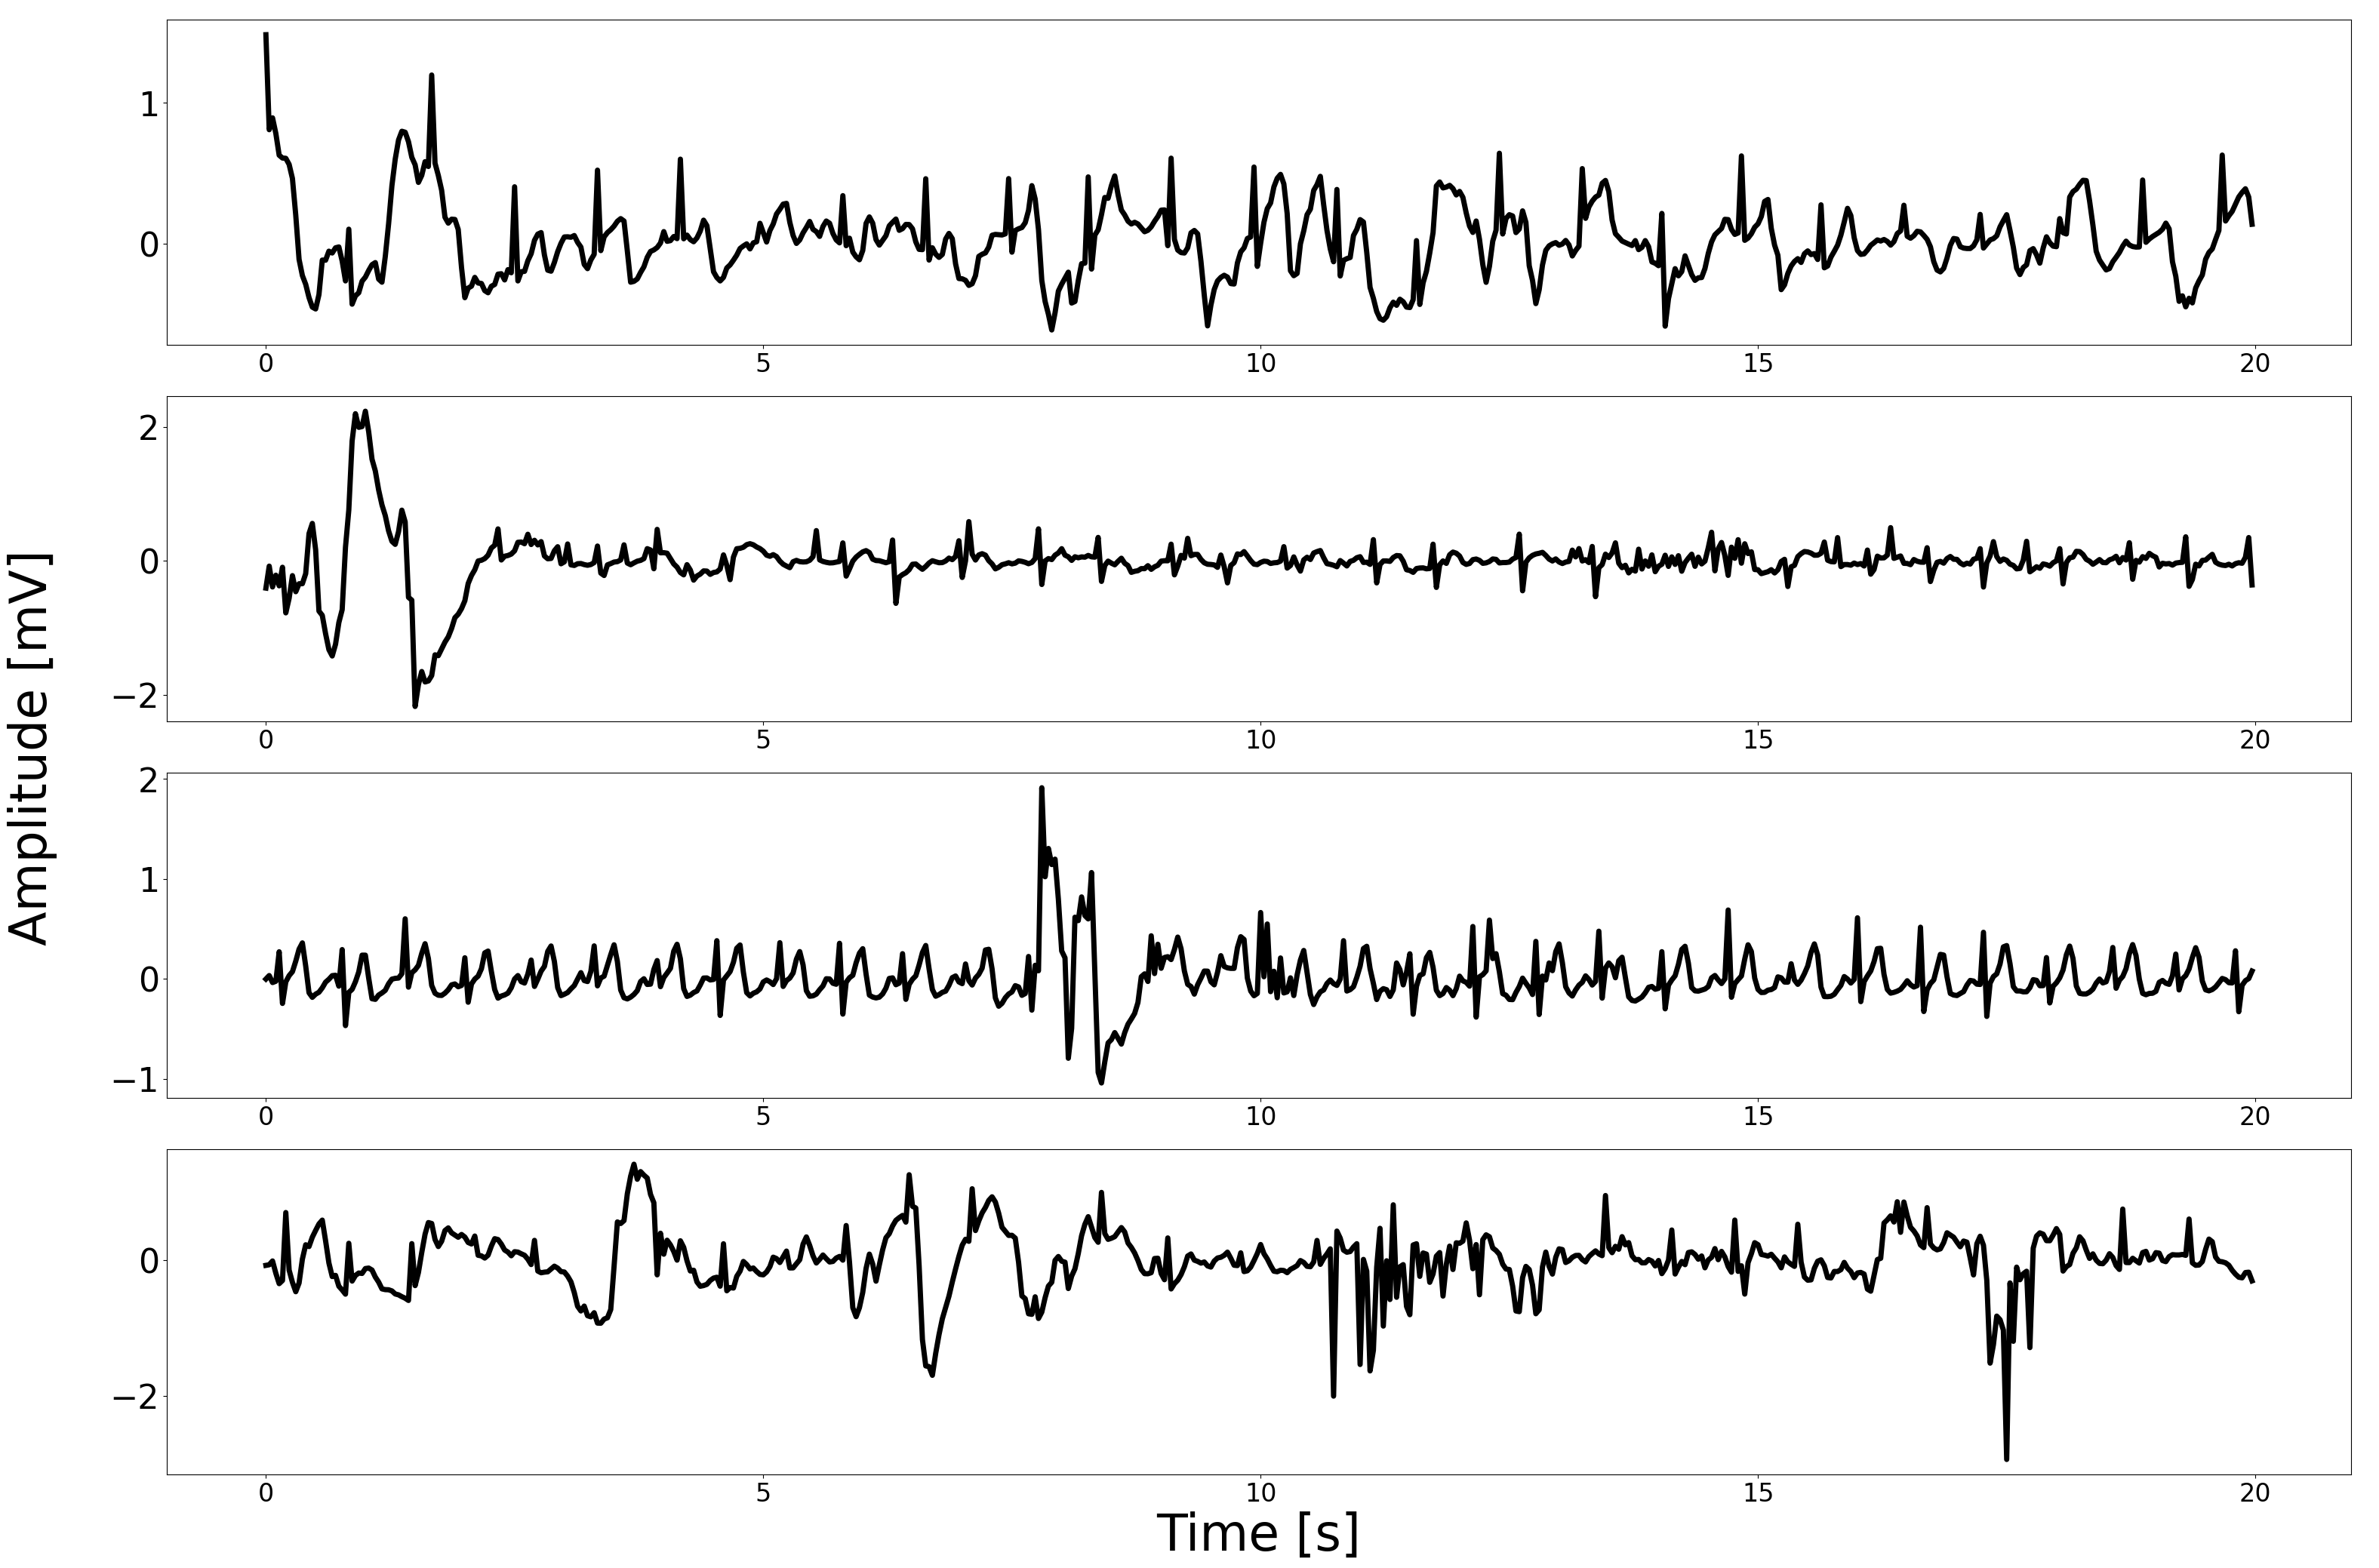

In [11]:
# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(4, 1)

seconds = np.arange(0, 600) / 30 
x_labels = [0, 5, 10, 15, 20]

for class_id in range(num_classes):
    ax = axs[class_id]
    #ax.set_title("Class {}".format(class_id))
    
    measurements = data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

In [13]:
def plot_features(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')

In [14]:
signal = data.loc[sample_signal_ids[0]].dropna().to_numpy(dtype='float32')
r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']
beats.shape

(33, 180)

/tmp/ipykernel_43324/2348902154.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')


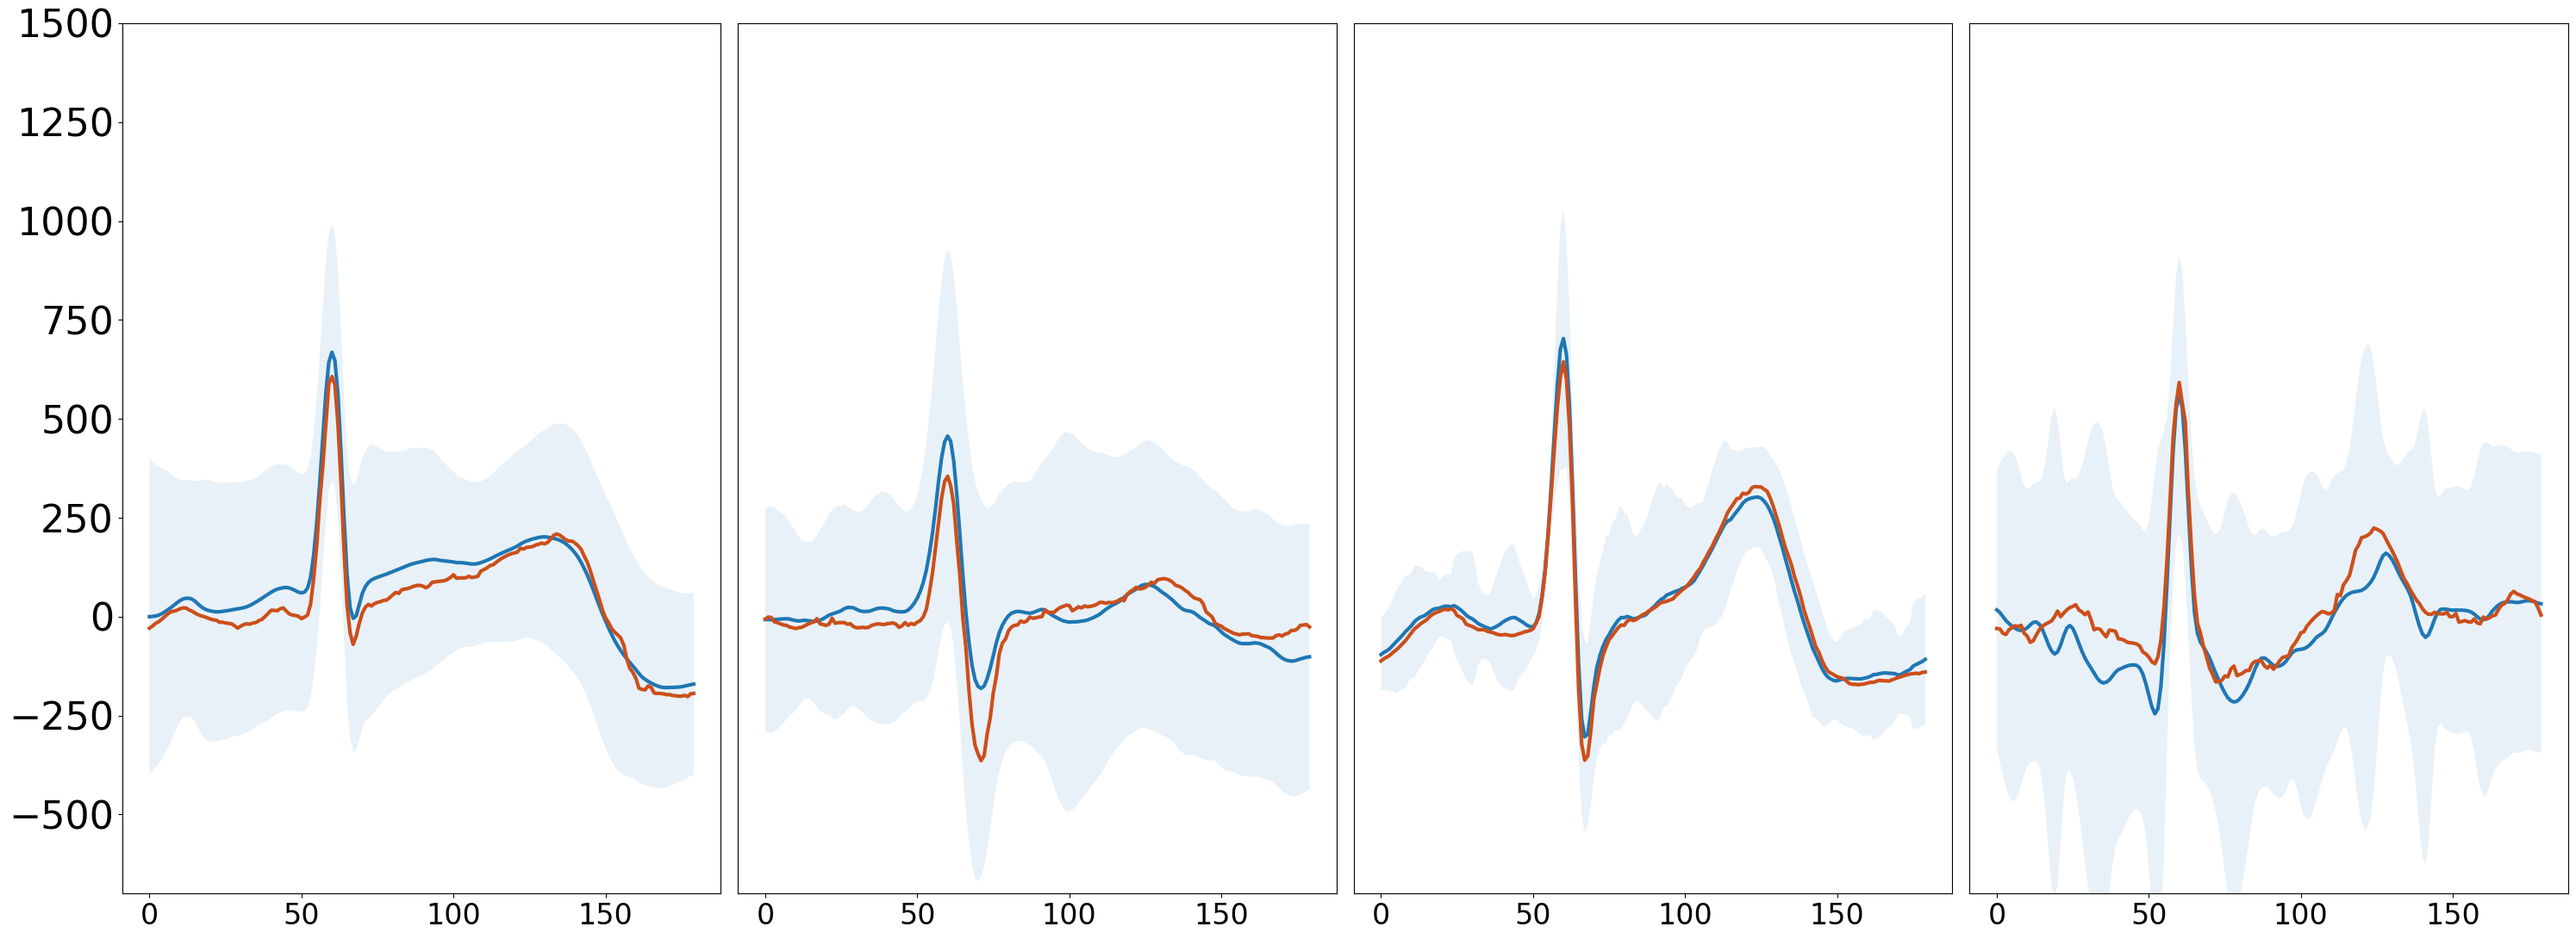

In [15]:
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
for class_id in range(num_classes):
    ax = plt.subplot(1, 4, class_id + 1)
    #ax.set_title("Class {}".format(class_id))
    ax.set_ylim([-700, 1500])
    if class_id:
        ax.set_yticks([])
    plot_features(data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

In [16]:
def preprocess(i):
    signal =data.loc[i].dropna().to_numpy(dtype='float32')
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu=np.array([])
            var=np.array([])
            md = np.array([])
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            return mu,var,md
        else:
            return np.array([]),np.array([]),np.array([])
    return np.array([]),np.array([]),np.array([])


In [17]:
np.array([]).shape[0] !=0

False

In [18]:
x = []
x_index = []
for i in range(data.shape[0]):
    if (i%200 ==0):
        print(i)
    
    mu,var,md =preprocess(i)
    if(mu.shape[0]!=0):
        
        x.append(np.append(np.append(mu,var),md))
        x_index.append(i)
x = np.array(x)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000


In [19]:
labels_array = labels['y'].to_numpy()
y= labels_array[x_index]
print(y.shape,x.shape)
with open('x.npy','wb') as f:
    np.save(f,x)
with open('y.npy','wb') as f:
    np.save(f,y)

(5082,) (5082, 540)


In [20]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(max_depth=20, random_state=0)
# clf.fit(x,y)
# clf.score(x,y)

0.9988193624557261

In [21]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(clf, x, y, cv=5)

array([0.66273353, 0.66764995, 0.68503937, 0.66535433, 0.65354331])

In [22]:
# from sklearn.svm import SVC
# clf =SVC()
# clf.fit(x,y)
# cross_val_score(clf, x, y, cv=5)

array([0.61750246, 0.63421829, 0.64173228, 0.63484252, 0.63681102])

In [23]:
# do feature selection?         pca?                
# outlier detection?            use zscore? isolation forest?
#missing value filling. no need

In [24]:
# from sklearn.ensemble import IsolationForest
# model=IsolationForest(n_estimators=50, max_samples='auto')  
# model.fit(x)
# model.predict(x)

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto')  
model.fit(x)
model.predict(x)
non_outlier_index = (model.predict(x)==1)
x_pruned=x[non_outlier_index]
y_pruned = y[non_outlier_index]
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_pruned, y_pruned)
print(clf.feature_importances_ )
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(x_pruned)
X_new.shape


In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
# clf = ExtraTreesClassifier(n_estimators=50)
# clf = clf.fit(x_pruned, y_pruned)
# print(clf.feature_importances_ )
# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(x_pruned)
# X_new.shape


In [27]:
# clf = RandomForestClassifier(max_depth=20, random_state=0)
# clf.fit(x_pruned,y_pruned)
# print(clf.score(x_pruned,y_pruned))
# cross_val_score(clf, x_pruned, y_pruned, cv=5)


0.9987333755541482


array([0.66983122, 0.68037975, 0.6937698 , 0.67687434, 0.67581837])

In [28]:
# clf = RandomForestClassifier(max_depth=20, random_state=0)
# clf.fit(x_pruned,y_pruned)
# print(clf.score(x_pruned,y_pruned))
# cross_val_score(clf, X_new, y_pruned, cv=5)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_val, y_train, y_val = train_test_split(    X_new, y_pruned, test_size=0.2, random_state=0)
clf = RandomForestClassifier(max_depth=30, random_state=0)
clf.fit(X_train,y_train)
F1 = f1_score(y_val, clf.predict(X_val), average='micro')
F1

0.6856540084388185

In [30]:
# get xgboost

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
F1 = f1_score(y_val, model.predict(X_val), average='micro')
#todo: hyper parameter selection.

In [31]:
F1

0.6856540084388185

In [32]:
# get feature selection 
# get mean variance, mode max min, at each time stamp, and over all of all peaks,

# calculate the intervals
import neurokit2 as nk
signal = data.loc[sample_signal_ids[0]].dropna().to_numpy(dtype='float32')
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=300)
rpeaks

{'ECG_R_Peaks': array([ 263,  507,  754, 1002, 1252, 1499, 1749, 2001, 2249, 2495, 2744,
        2992, 3239, 3482, 3730, 3981, 4229, 4473, 4722, 4968, 5209, 5449,
        5693, 5937, 6175, 6415, 6658, 6898, 7133, 7376, 7618, 7861, 8099]),
 'sampling_rate': 300}

In [33]:
r_peaks2 = ecg.engzee_segmenter(signal, 300)['rpeaks']
r_peaks2
# try out rnn. find a paper for using rnn in ecg.

array([  26,  263,  507,  801, 1002, 1252, 1499, 1749, 2001, 2249, 2495,
       2744, 2992, 3239, 3482, 3730, 3981, 4229, 4473, 4722, 4968, 5209,
       5449, 5693, 5937, 6175, 6415, 6658, 6898, 7133, 7376, 7618, 7861,
       8099])

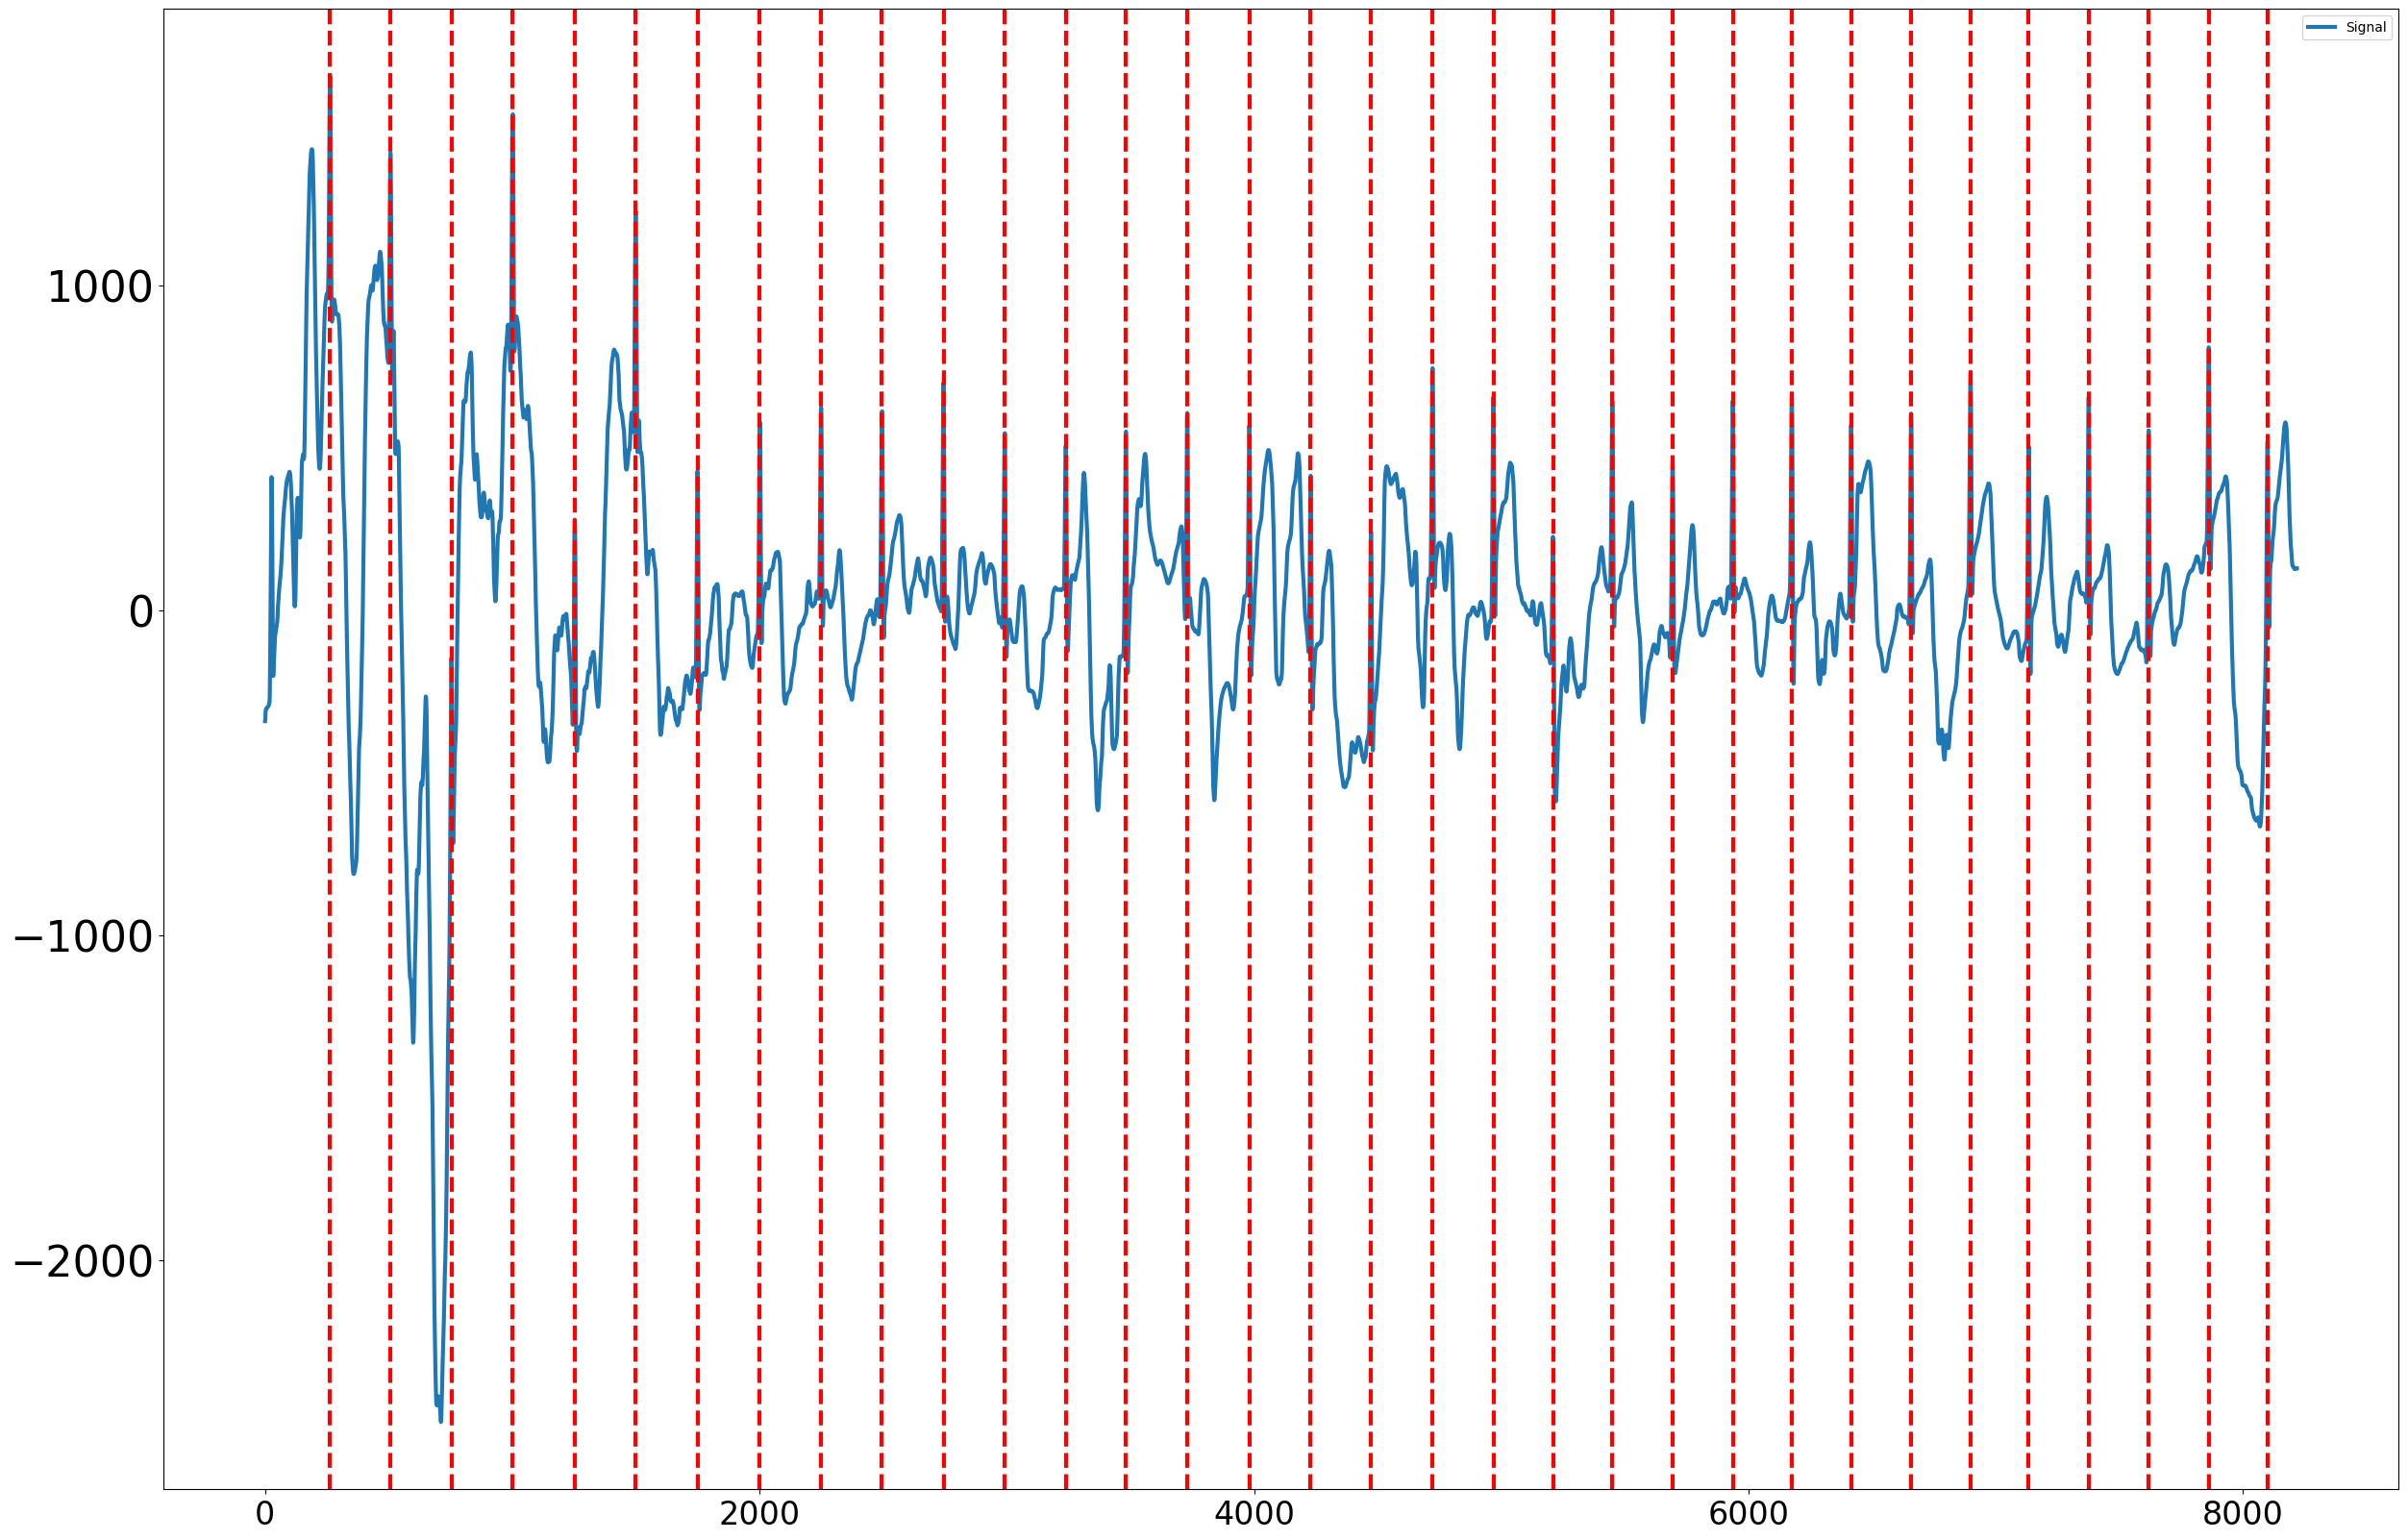

In [34]:
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], signal)

In [38]:
_, waves_peak = nk.ecg_delineate(signal, rpeaks, sampling_rate=300, method="peak")


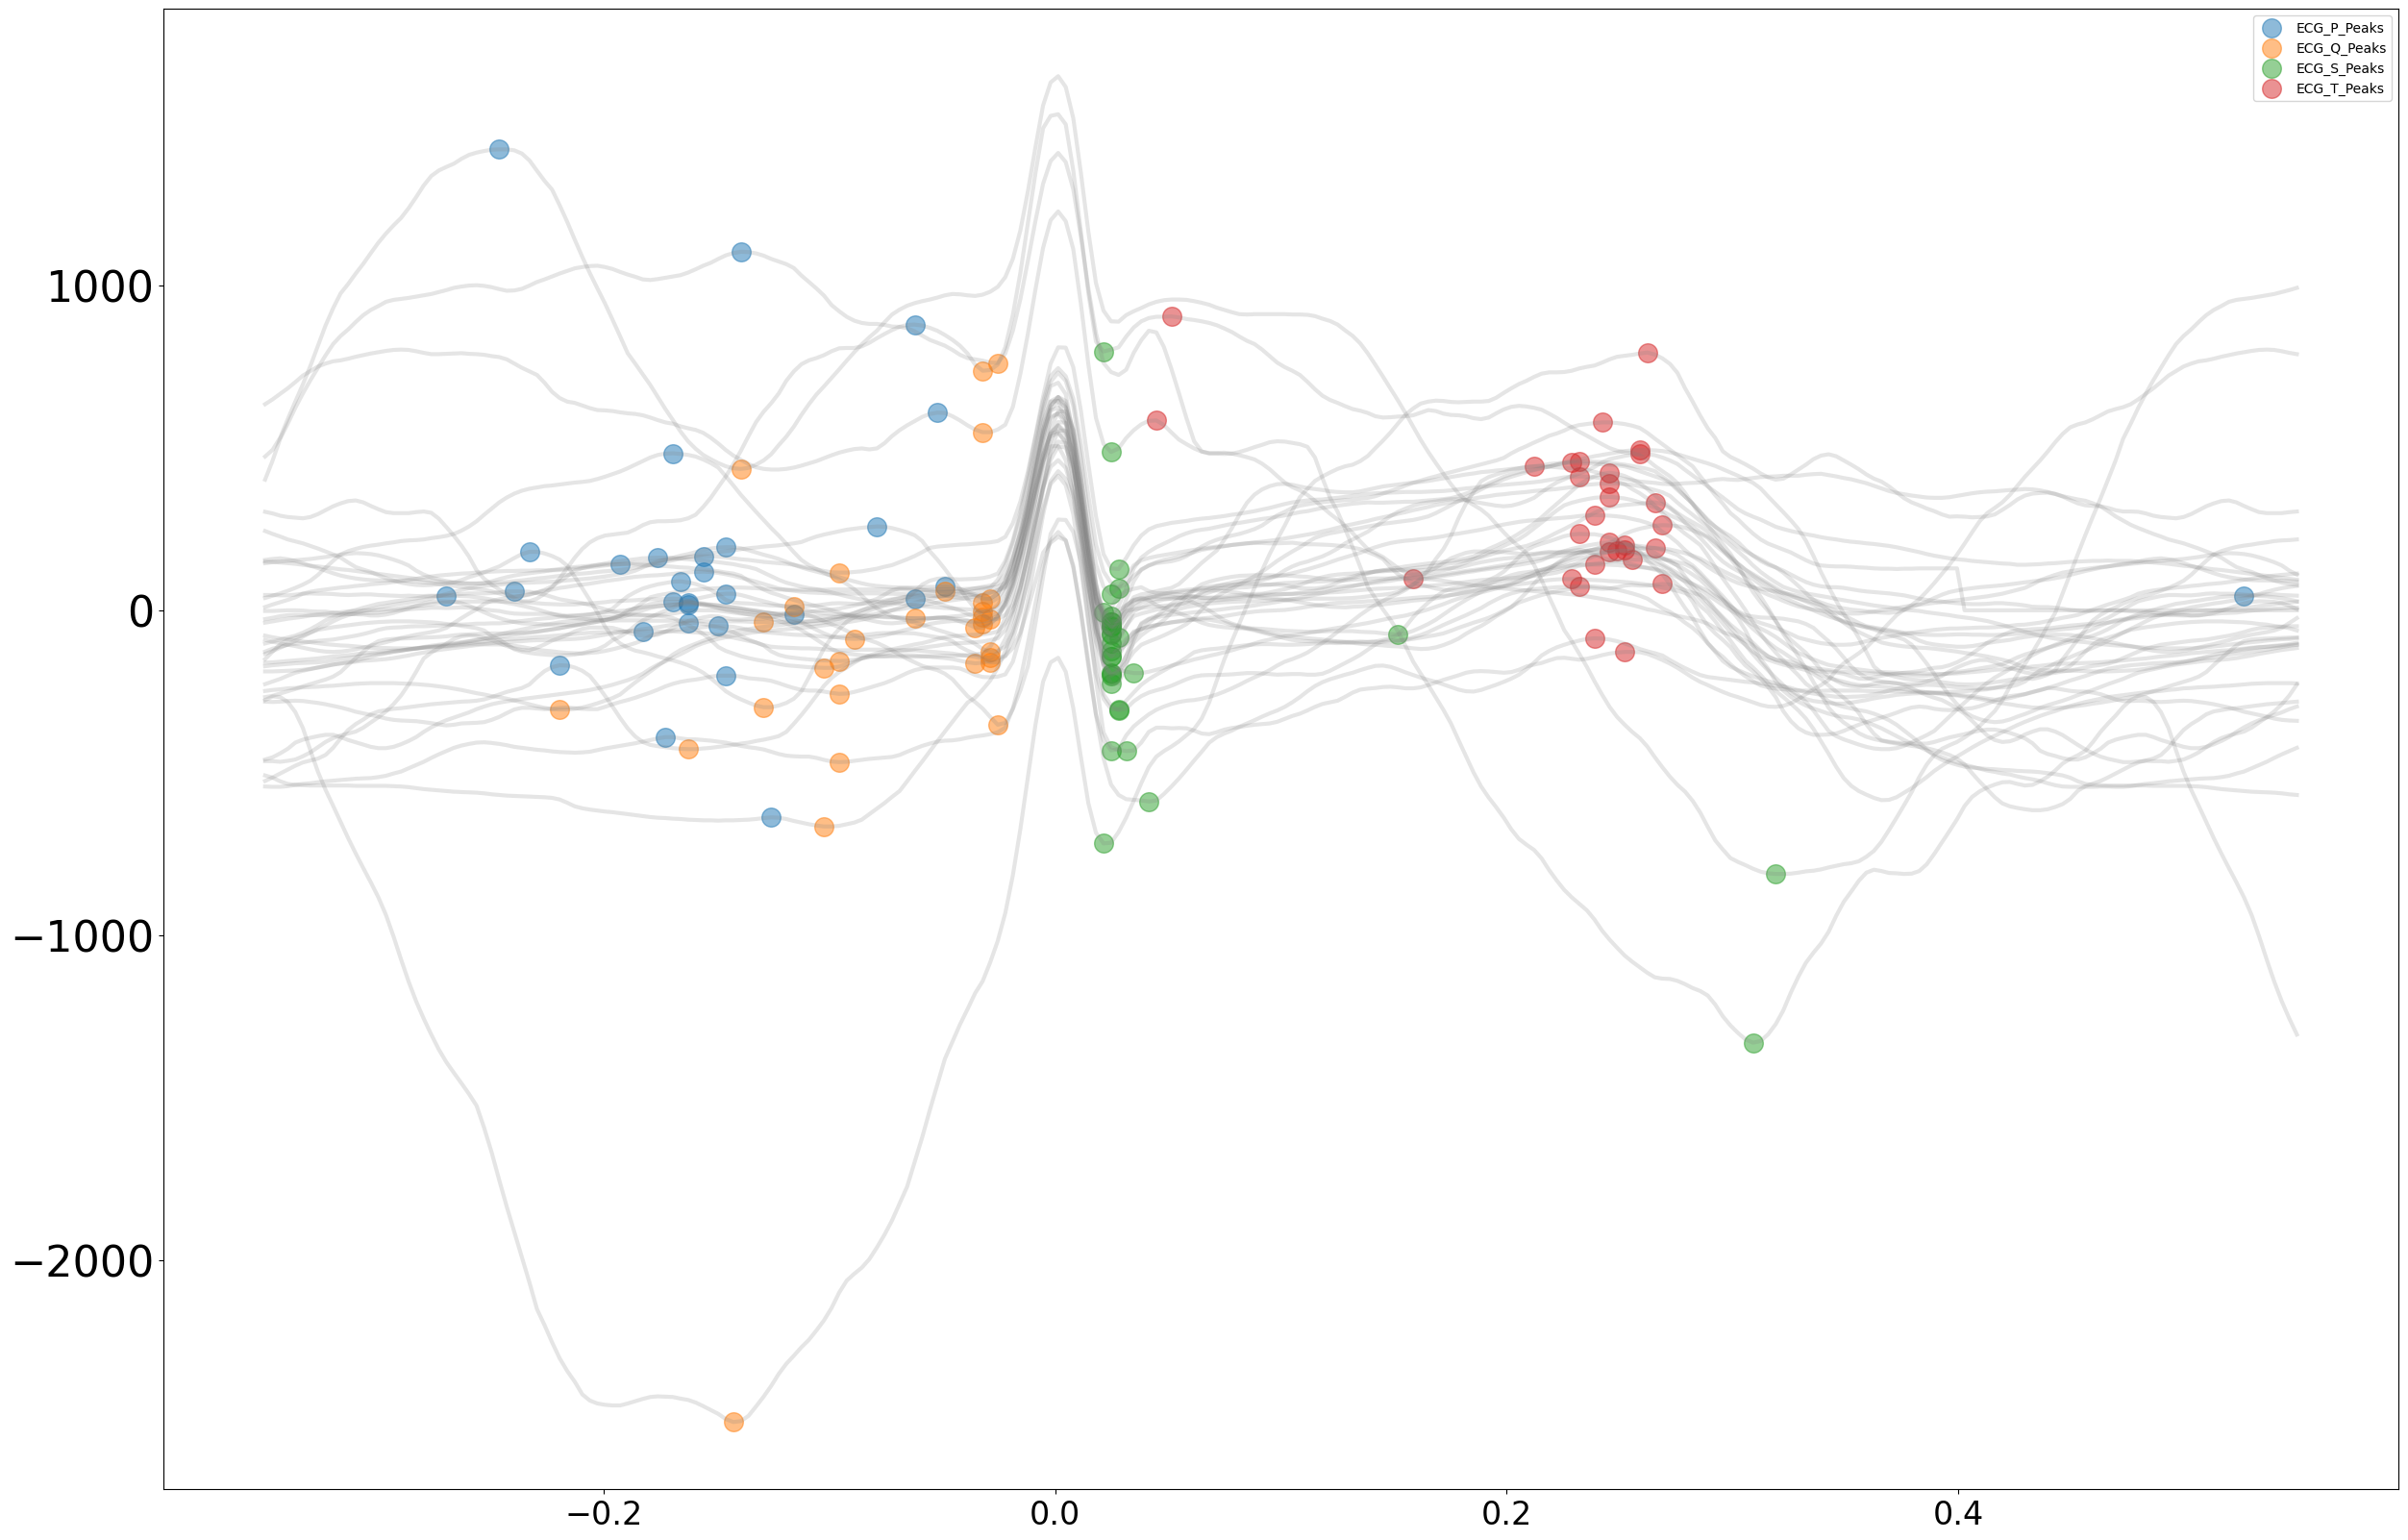

In [39]:
_, waves_peak = nk.ecg_delineate(signal, 
                                 rpeaks, 
                                 sampling_rate=300, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

In [112]:
a= np.array([nan])

NameError: name 'nan' is not defined

In [1]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
labels = pd.read_csv('y_train.csv', index_col='id')
data = pd.read_csv('X_train.csv', index_col='id')

In [85]:
import neurokit2 as nk
def feature_extraction(index,data):
    sampling_rate =300
    signal = data.loc[index].dropna().to_numpy(dtype='float32') # todo: clean data here
    features = []
    #print(signal.shape)
    #signals,info = nk.ecg_process(signal,sampling_rate = sampling_rate)
    
    #R_peaks = ecg.engzee_segmenter(signal, sampling_rate)['rpeaks']
    
    cleaned_ecg = nk.ecg_clean(signal, sampling_rate=sampling_rate, method='neurokit')
    _, R_peaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=sampling_rate)
    R_peaks = R_peaks["ECG_R_Peaks"]
    #R_peaks = R_peaks
    #R_peaks = info["ECG_R_Peaks"]
    #cleaned_ecg = signals["ECG_Clean"].to_numpy()
    try:
        peak_signals, peak_waves = nk.ecg_delineate(cleaned_ecg, R_peaks, sampling_rate=sampling_rate, method='dwt')
    except:
        return np.array([])
    # T_peaks = np.argwhere( peak_waves['ECG_T_Peaks'].to_numpy())
    
    # P_peaks = np.argwhere(peak_waves['ECG_P_Peaks'].to_numpy())
    # Q_peaks = np.argwhere(peak_waves['ECG_Q_Peaks'].to_numpy())
    # S_peaks = np.argwhere(peak_waves['ECG_S_Peaks'].to_numpy())
    T_peaks = np.array( peak_waves['ECG_T_Peaks'])
    
    P_peaks = np.array(peak_waves['ECG_P_Peaks'])
    Q_peaks = np.array(peak_waves['ECG_Q_Peaks'])
    S_peaks = np.array(peak_waves['ECG_S_Peaks']) # note: this can havee nan in their value
    sl_PR = np.min([R_peaks.shape[0] , P_peaks.shape[0]])
    PR_interval = R_peaks[:sl_PR]-P_peaks[:sl_PR]
    shortestlength_rs = np.min([S_peaks.shape[0] , Q_peaks.shape[0]])
    KURS_duration = S_peaks[:shortestlength_rs]-Q_peaks[:shortestlength_rs]
    PR_interval=PR_interval[~np.isnan(PR_interval)].astype(int)
    KURS_duration=KURS_duration[~np.isnan(KURS_duration)].astype(int)
    #print(S_peaks.shape)
    # if np.any( np.isnan(T_peaks)):
    #     print("shit")
    # if np.any( np.isnan(P_peaks)):
    #     print("shit")
    # if np.any (np.isnan(S_peaks)):
    #     print("shit")
    # if np.any (np.isnan(Q_peaks)):
    #     print("shit")    
    T_peaks=T_peaks[~np.isnan(T_peaks)].astype(int)
    P_peaks=P_peaks[~np.isnan(P_peaks)].astype(int)
    Q_peaks=Q_peaks[~np.isnan(Q_peaks)].astype(int)
    S_peaks=S_peaks[~np.isnan(S_peaks)].astype(int)
    #print("P_peaks, ",P_peaks)
    #print(S_peaks)
    #T_peaks = waves_peak['ECG_T_Peaks']
    # get mean and variance and min and max of amplitude
    def get_peak_stats(peaks):
        if peaks.shape[0]!=0:
            #print(peaks)
            return np.mean(peaks),np.var(peaks),np.max(peaks),np.min(peaks)
        
    def get_interval(P_peaks,Q_peaks,R_peaks,S_peaks,T_peaks):
        shortestlength_PR = np.min([R_peaks.shape[0] , P_peaks.shape[0]])
        PR_interval = R_peaks[:shortestlength_PR]- P_peaks[:shortestlength_PR]
        shortestlength_rs = np.min([S_peaks.shape[0] , Q_peaks.shape[0]])
        KURS_duration = S_peaks[:shortestlength_rs] - Q_peaks[:shortestlength_rs]
        return PR_interval,KURS_duration
    def get_heartbeat(signal):
        r_peaks = ecg.engzee_segmenter(signal, sampling_rate)['rpeaks']
        if len(r_peaks) >= 2:
            #print(ecg.extract_heartbeats(signal, r_peaks, 300))
            beats = ecg.extract_heartbeats(signal, r_peaks, sampling_rate)['templates']

            if len(beats) != 0:
                mu=np.array([])
                var=np.array([])
                md = np.array([])
                mu = np.mean(beats, axis=0) 
                var = np.std(beats, axis=0)
                md = np.median(beats, axis=0)
                return mu,var,md
            else:
                return np.array([]),np.array([]),np.array([])
        return np.array([]),np.array([]),np.array([])
    #get heartbeat franency

    beat_rate = nk.ecg_rate(R_peaks,sampling_rate =sampling_rate)
    #features.append(beat_rate)

    #get the stats of interval

    #PR_interval,KURS_duration = get_interval(P_peaks,Q_peaks,R_peaks,S_peaks,T_peaks)
    #features.append(PR_interval)
    #features.append(KURS_duration)
    def add_features(origin):
        if origin.shape[0]!=0:
            mean,var,maxv,minv = get_peak_stats(origin)
        
            features.append(mean)
            features.append(var)
            features.append(maxv)
            features.append(minv)
            return 0
        else:
            return 1
    count =0
    count +=add_features(beat_rate)
    count +=add_features(PR_interval)
    count +=add_features(KURS_duration)
    count +=add_features(P_peaks)    #todo: get the magnitude information
    count +=add_features(Q_peaks)
    count +=add_features(R_peaks)
    count +=add_features(S_peaks)
    count +=add_features(T_peaks)
    count +=add_features(cleaned_ecg[P_peaks])
    count +=add_features(cleaned_ecg[Q_peaks])
    count +=add_features(cleaned_ecg[R_peaks])
    count +=add_features(cleaned_ecg[S_peaks])
    count +=add_features(cleaned_ecg[T_peaks])
    if count>0:
        print("shit")
        return np.array([])
    #print("first, ",features)
    #print(np.array(features).shape)
    #return np.array(features)
    mu,var,md= get_heartbeat(signal)
    if mu.shape[0]!=0:
        #print("mu",mu)
        #print("var",var)
        features.append(np.mean(mu))
        features.append(np.mean(var))
        features.append(np.var(var))
        #print(features)
        features = np.array(features)
        features = np.append(np.append(features,mu),var)
        return features
    else:
        return np.array([])
#todo: get them all in one array.
# p ku r s t get mean and variance of interval

In [3]:
from tqdm import tqdm
import warnings

np.seterr(all="ignore")
x=[]
x_index=[]
for i in tqdm(range(0,data.shape[0])):
    # if (i%200 ==0):
    #     print(i)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        features = feature_extraction(i)
    #print(features.shape)
    if(features.shape[0]!=0):
        x.append(features)
        #print(features.shape)
        x_index.append(i)
   
x = np.array(x)
labels_array = labels['y'].to_numpy()
y = labels_array[x_index]
with open('x_v1.npy', 'wb') as f:
    np.save(f, x)
with open('y_v1.npy', 'wb') as f:
    np.save(f, y)

  4%|▎         | 188/5117 [00:52<20:31,  4.00it/s]

shit


 13%|█▎        | 643/5117 [03:24<23:24,  3.19it/s]

shit


 26%|██▌       | 1323/5117 [07:13<22:25,  2.82it/s]

shit


 53%|█████▎    | 2713/5117 [14:32<13:05,  3.06it/s]

shit


 63%|██████▎   | 3246/5117 [17:27<09:33,  3.26it/s]

shit


 68%|██████▊   | 3500/5117 [18:52<07:12,  3.74it/s]

shit


 78%|███████▊  | 3980/5117 [21:36<07:14,  2.61it/s]

shit


 96%|█████████▌| 4901/5117 [26:41<00:58,  3.67it/s]

shit


 97%|█████████▋| 4972/5117 [27:04<00:36,  3.96it/s]

shit


100%|██████████| 5117/5117 [27:47<00:00,  3.07it/s]


In [74]:
signal = data.loc[0].dropna().to_numpy(dtype='float32')
signals, info = nk.ecg_process(signal, sampling_rate=300)


In [6]:
x.shape

(5061, 415)

In [107]:
cleaned_ecg = nk.ecg_clean(signal, sampling_rate=300, method='neurokit')
cleaned_ecg

array([ 26.60090522,  29.28583889,  32.02673737, ..., -44.93023267,
       -36.71436922, -28.16187504])

In [144]:
_, R_peaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=300)
R_peaks = R_peaks["ECG_R_Peaks"]

{'ECG_R_Peaks': array([  102,   199,   448,   695,   948,  1204,  1459,  1710,  1966,
         2220,  2471,  2723,  2976,  3229,  3476,  3726,  3981,  4231,
         4478,  4727,  4971,  5214,  5453,  5692,  5929,  6162,  6399,
         6635,  6872,  7105,  7332,  7560,  7794,  8035,  8277,  8519,
         8767,  9014,  9265,  9514,  9762, 10013, 10261, 10509, 10755,
        11006, 11256, 11507, 11755, 12005, 12255, 12505, 12757, 13010,
        13257, 13504, 13754, 14006, 14259, 14509, 14760, 15012, 15263,
        15512, 15762, 16011, 16256]),
 'sampling_rate': 300}

In [102]:

cleaned_ecg = signals["ECG_Clean"].to_numpy()
print(cleaned_ecg)
#T_peaks = np.argwhere( signals['ECG_T_Peaks'].to_numpy())
print(signals['ECG_T_Peaks'].to_numpy())
print(cleaned_ecg[np.argwhere(signals['ECG_P_Peaks'].to_numpy())])
print(cleaned_ecg[np.argwhere(signals['ECG_T_Peaks'].to_numpy())].shape)


0        26.600905
1        29.285839
2        32.026737
3        35.018384
4        38.594380
           ...    
16317   -59.926963
16318   -52.662674
16319   -44.930233
16320   -36.714369
16321   -28.161875
Name: ECG_Clean, Length: 16322, dtype: float64
[0 0 0 ... 0 0 0]


ValueError: Cannot index with multidimensional key

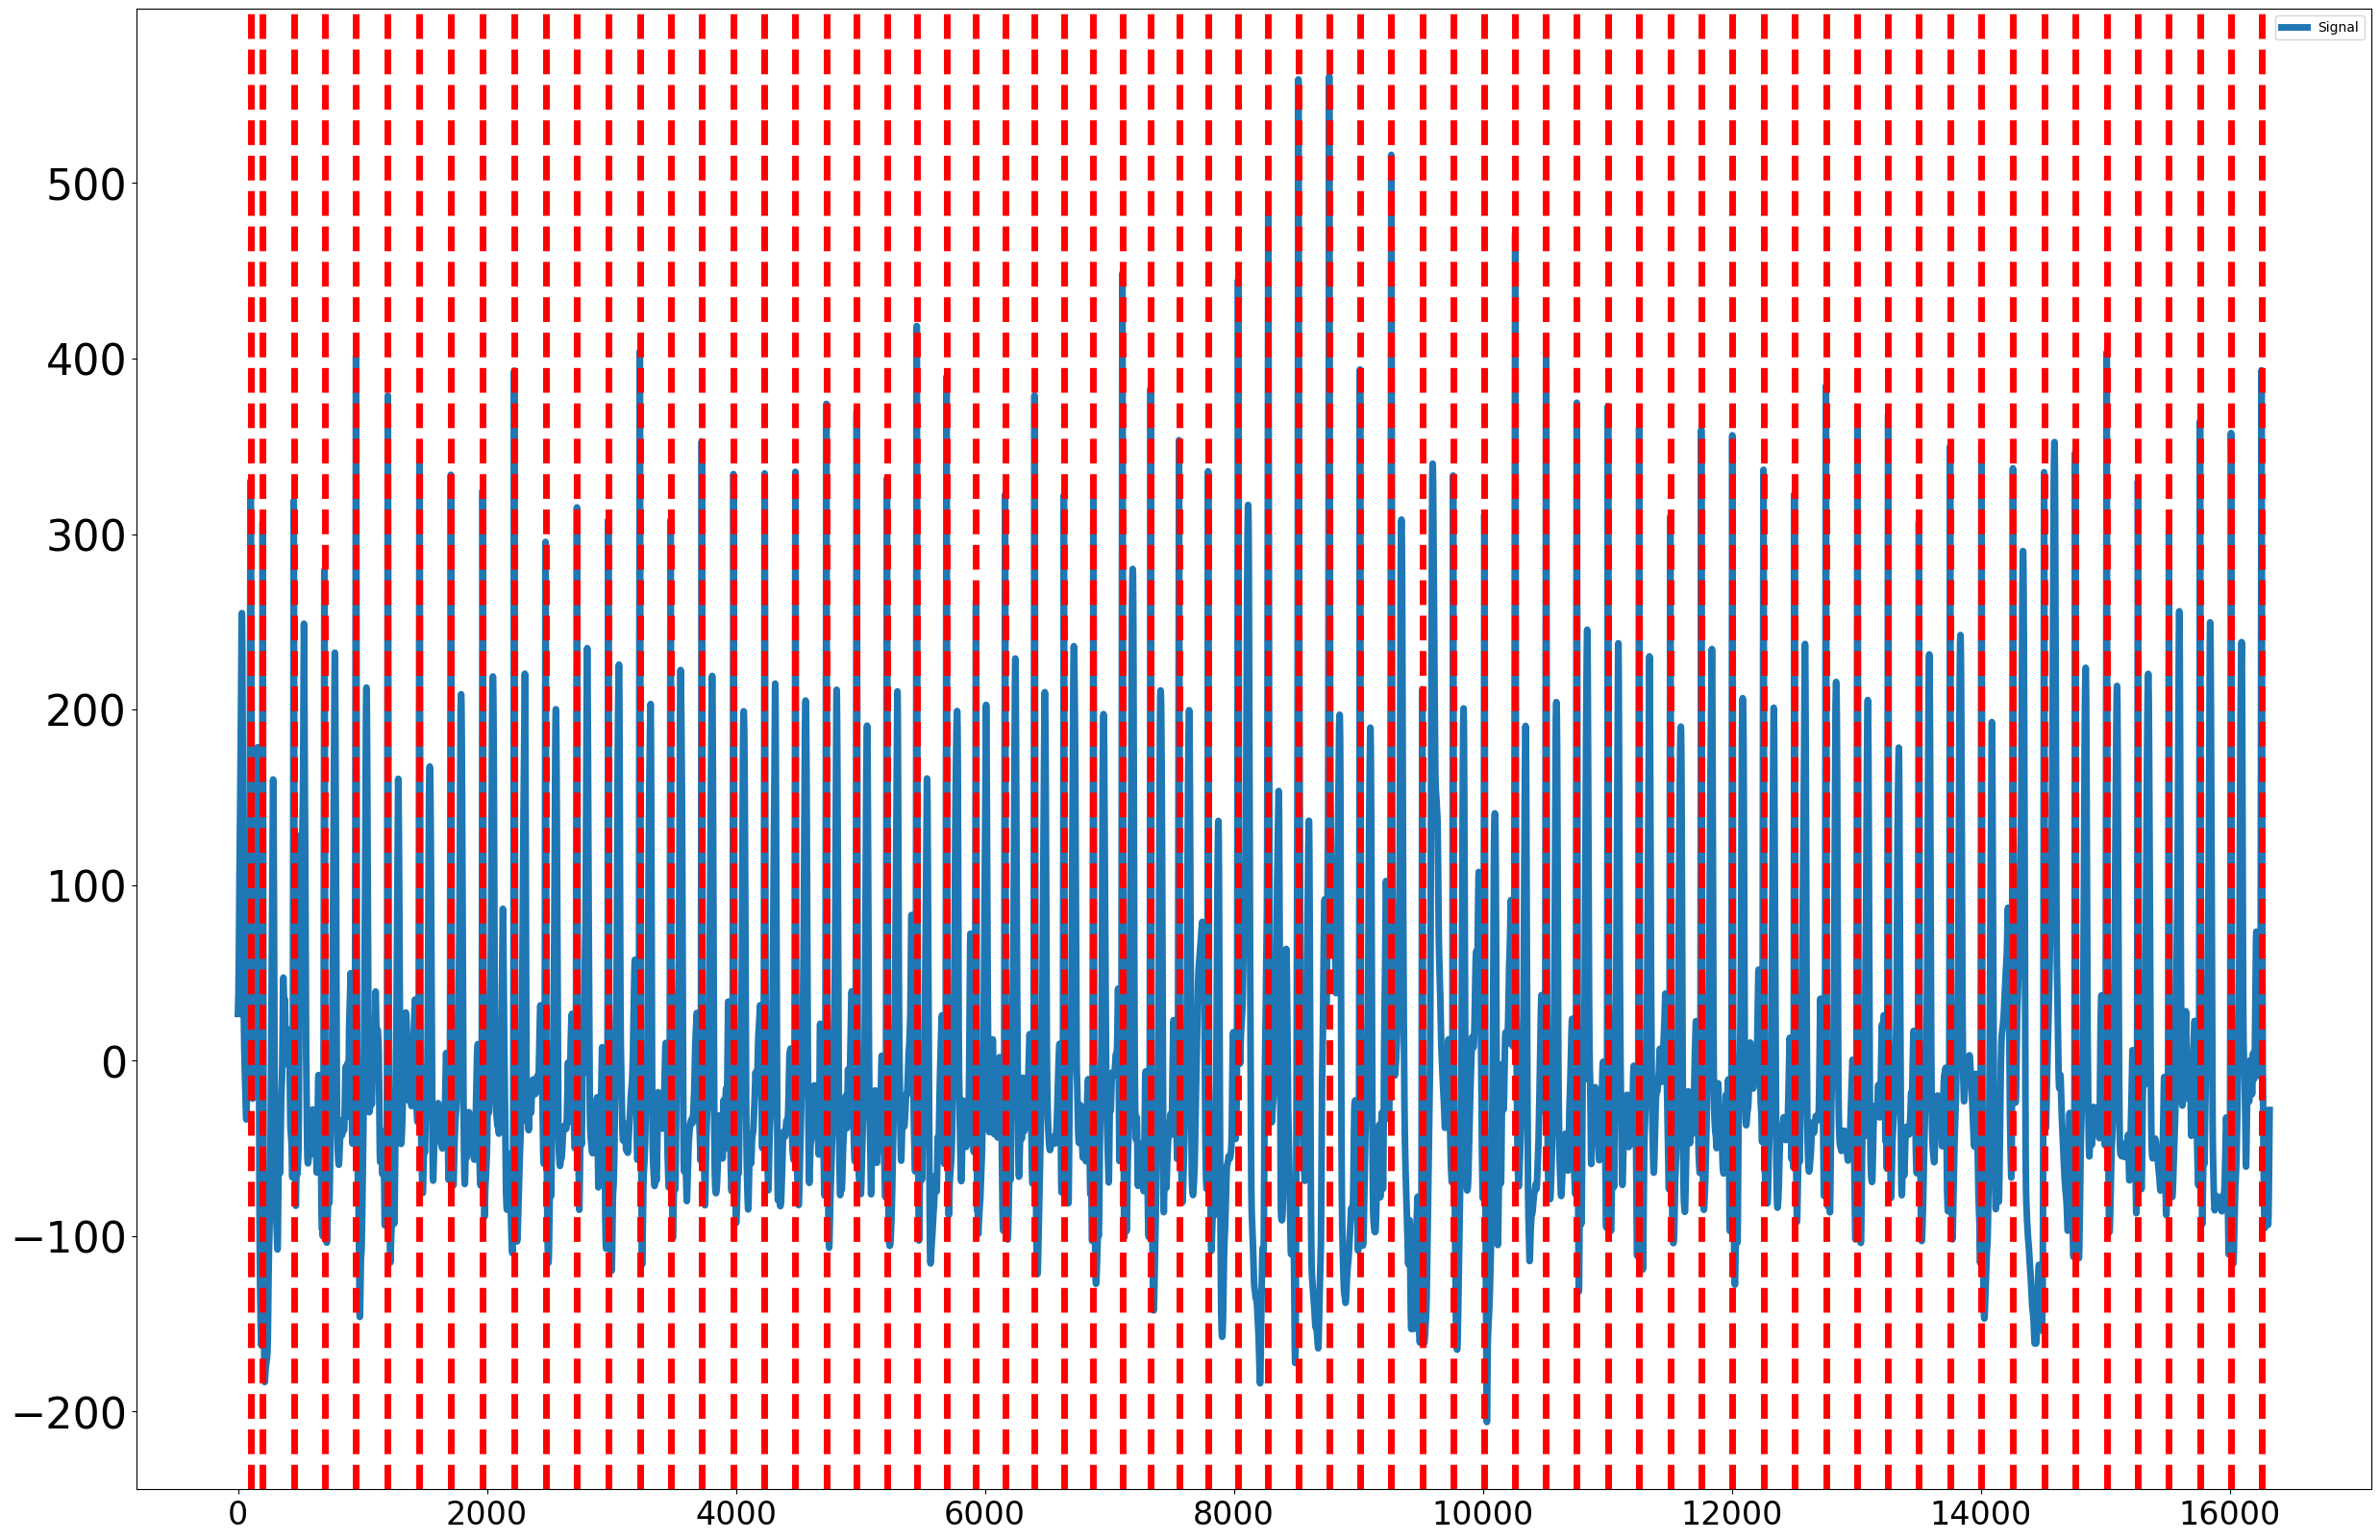

In [76]:
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals["ECG_Clean"]
plot = nk.events_plot(rpeaks, cleaned_ecg)


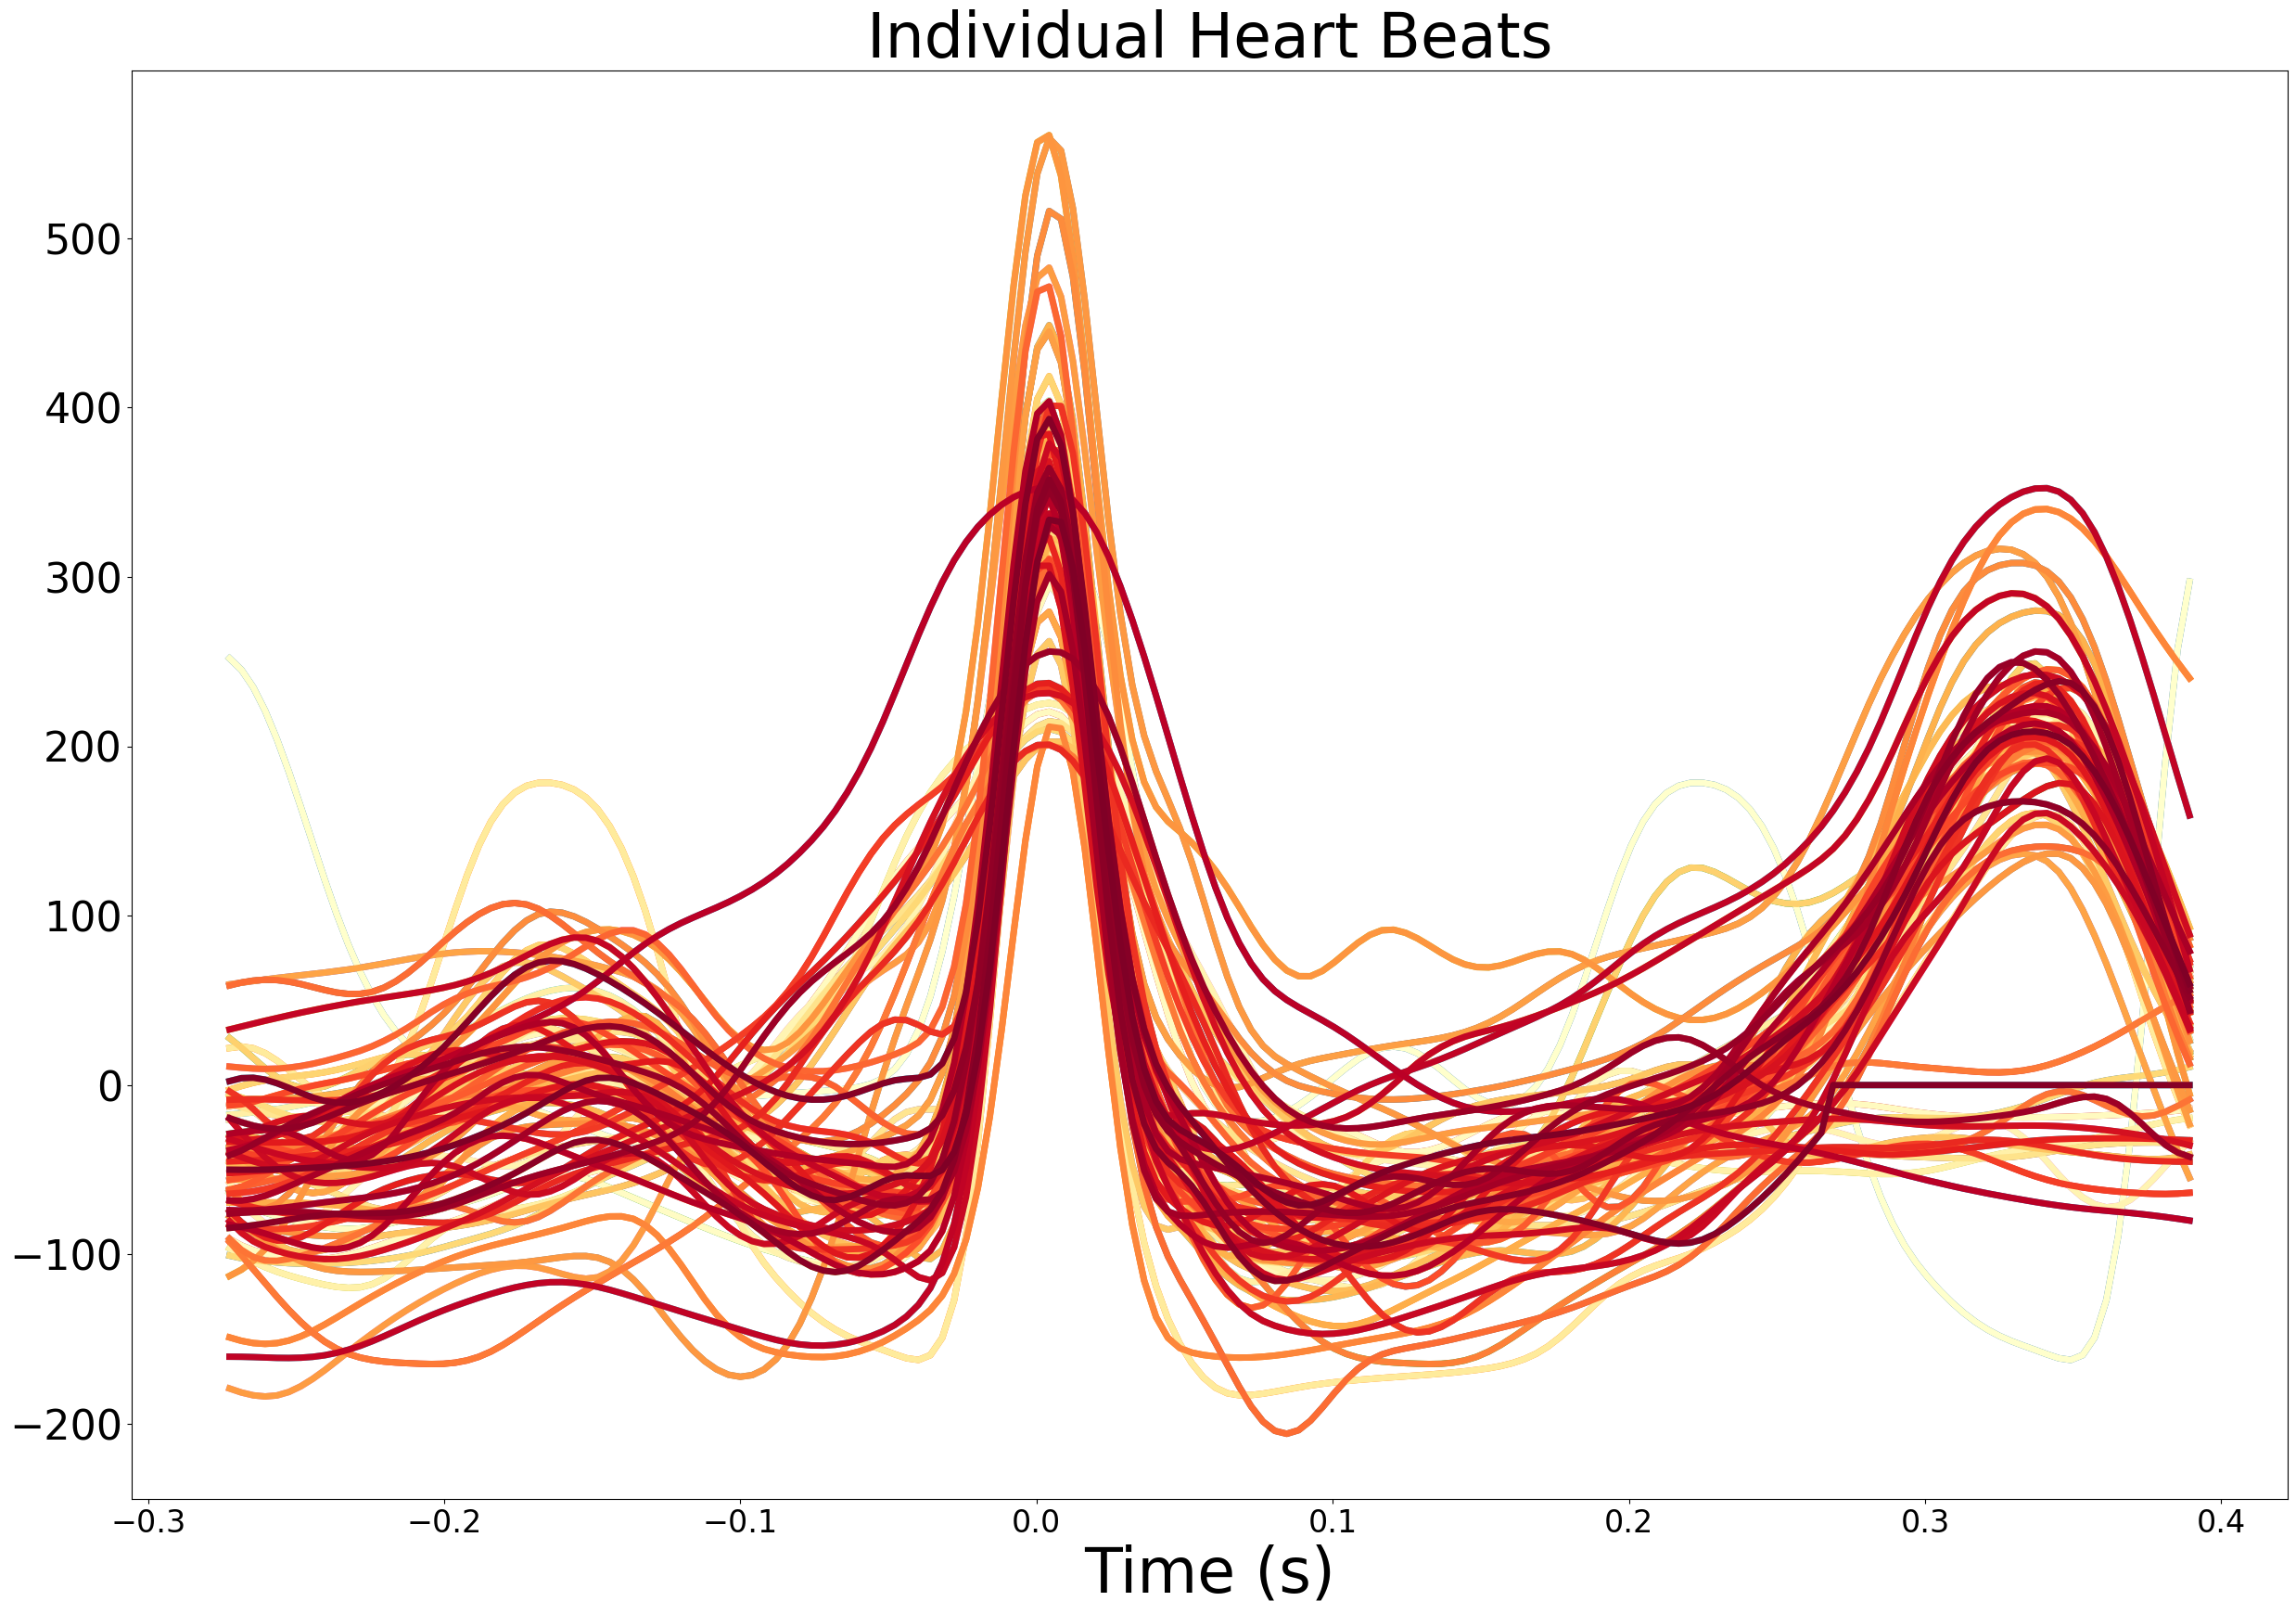

In [54]:
epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=250, show=True)

In [60]:
epochs["1"]

,Signal,Index,Label
-0.272514,251.938688,33,1
-0.268503,245.202852,34,1
-0.264492,234.857842,35,1
-0.260481,220.987007,36,1
-0.256470,204.062586,37,1
...,...,...,...
0.373262,36.679602,194,1
0.377273,115.656745,195,1
0.381284,193.191351,196,1
0.385295,257.338962,197,1


In [45]:
data.shape[0]

5117

In [ ]:
with open('test.npy', 'wb') as f:
    np.save(f, np.array([1, 2]))

In [16]:
x=None
y=None

#x=  np.load('x_fandh.npy')
y= np.load('y_fandh.npy',allow_pickle=True) 

In [18]:
y.shape

(5070,)

In [49]:

#X_new.shape

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x_train, X_val, y_train, y_val = train_test_split(    x, y, test_size=0.2, random_state=0)
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto')  
model.fit(x_train)

non_outlier_index = (model.predict(x_train)==1)
x_pruned=x_train[non_outlier_index]
y_pruned = y_train[non_outlier_index]
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_pruned, y_pruned)
#print(clf.feature_importances_ )
trans_model = SelectFromModel(clf, prefit=True)
X_train_new = trans_model.transform(x_pruned)
X_val_new = trans_model.transform(X_val)

# model = XGBClassifier()
# model.fit(X_train_new, y_pruned)
# F1 = f1_score(y_val, model.predict(X_val_new), average='micro')

In [17]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='error', feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [50]:

from xgboost import XGBClassifier
# setup parameters for xgboost
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "error"
param['eta'] = 0.3
param['gamma'] = 0
param['max_depth'] = 15
param['min_child_weight']=1
param['max_delta_step'] = 0
param['subsample']= 1
param['colsample_bytree']=1
param['silent'] = 1
param['seed'] = 0
param['base_score'] = 0.5
param['grow_policy'] ="lossguide"
param
model = XGBClassifier()
model.set_params(**param)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='error', feature_types=None, gamma=0, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=15, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [84]:
f1_score(y_val, model.predict(X_val_new), average='micro')

0.7709772951628825

In [51]:

model.fit(X_train_new, y_pruned)
F1 = f1_score(y_val, model.predict(X_val_new), average='micro')
F1

[23:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.7709772951628825

In [ ]:
data_test = pd.read_csv('X_test.csv', index_col='id')

In [86]:

y_preds= []
# extract feature from test data , transform and give prediction.
for i in tqdm(range(0,data_test.shape[0])):
    # if (i%200 ==0):
    #     print(i)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        features = feature_extraction(i,data_test)
    if features.shape[0]!=0:
        features_new = trans_model.transform(features.reshape(1,-1))
        y_pred=model.predict(features_new)
        y_preds.append(y_pred)
        #todo add y_pred to output file
    else:
        #todo: add 0 to the prediction
        y_preds.append(0)
y_preds = np.array(y_preds)

df= pd.DataFrame(y_preds)
df.columns = ["y"]
df["id"] = np.arange(y_preds.shape[0])
df.to_csv('y_pred_dan.csv')

 15%|█▍        | 502/3411 [03:12<27:40,  1.75it/s]

shit


 20%|█▉        | 674/3411 [04:28<18:11,  2.51it/s]

shit


 22%|██▏       | 750/3411 [05:00<17:06,  2.59it/s]

shit


 23%|██▎       | 776/3411 [05:12<29:06,  1.51it/s]

shit


 24%|██▍       | 820/3411 [05:32<18:27,  2.34it/s]

shit


 25%|██▍       | 847/3411 [05:44<16:09,  2.65it/s]

shit


 53%|█████▎    | 1798/3411 [12:58<13:16,  2.03it/s]

shit


 56%|█████▋    | 1921/3411 [13:52<08:31,  2.91it/s]

shit


 70%|██████▉   | 2379/3411 [17:14<07:20,  2.34it/s]

shit


 79%|███████▊  | 2682/3411 [19:33<07:33,  1.61it/s]

shit


100%|██████████| 3411/3411 [24:53<00:00,  2.28it/s]
/tmp/ipykernel_38946/3354688933.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_preds = np.array(y_preds)


In [68]:
y_preds

0         0
1         0
2         0
3         1
4         2
       ... 
3406    [2]
3407    [0]
3408    [2]
3409    [0]
3410    [2]
Name: y, Length: 3411, dtype: object

In [83]:
y_preds = df["y"]

y_preds=np.array(y_preds,dtype=int)
df= pd.DataFrame(y_preds)
df.columns = ["y"]
df.to_csv('y_pred_dan.csv',index=True)


In [75]:
for i in range(y_preds.shape[0]):
   
    print(y_preds[i])
    
y_preds


0
0
0
1
2
1
0
1
2
0
2
0
0
0
2
0
1
2
2
0
2
0
2
0
0
0
2
0
2
1
3
0
0
3
0
0
2
0
2
0
2
0
0
0
0
0
0
0
2
2
0
0
0
1
2
2
0
0
2
0
2
0
0
2
0
0
2
0
0
2
0
3
0
0
3
2
0
1
0
0
0
0
2
0
3
0
0
2
0
2
2
0
2
0
0
0
1
0
0
0
2
0
0
3
0
2
0
0
1
2
0
0
0
0
2
2
2
0
0
0
0
0
2
1
0
0
2
2
3
0
0
1
0
0
0
0
0
2
1
0
0
0
0
0
1
1
2
0
0
2
0
0
0
0
0
0
0
2
0
0
2
0
0
2
0
1
0
0
0
2
0
3
2
2
0
2
0
0
0
2
0
0
2
2
0
2
0
0
[1]
[0]
[2]
[0]
[0]
[0]
[0]
[2]
[0]
[3]
[0]
[1]
[2]
[3]
[0]
[2]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[2]
[2]
[0]
[0]
[2]
[2]
[2]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[2]
[0]
[2]
[2]
[0]
[2]
[0]
[0]
[2]
[2]
[0]
[2]
[2]
[0]
[0]
[0]
[0]
[2]
[2]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[3]
[0]
[2]
[2]
[2]
[2]
[2]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[2]
[0]
[0]
[2]
[0]
[0]
[0]
[2]
[2]
[2]
[0]
[0]
[2]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[1]
[1]
[0]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[2]
[0]
[1]
[0]
[0]
[0]
[3]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]


0         0
1         0
2         0
3         1
4         2
       ... 
3406    [2]
3407    [0]
3408    [2]
3409    [0]
3410    [2]
Name: y, Length: 3411, dtype: object

In [59]:
df= pd.DataFrame(np.zeros(10))
df2 = pd.DataFrame()
df2.add(3)


""


In [60]:
df2

""


In [57]:
df['id'] = np.arange(10)
df

,0,id
0,0.0,0
1,0.0,1
2,0.0,2
3,0.0,3
4,0.0,4
5,0.0,5
6,0.0,6
7,0.0,7
8,0.0,8
9,0.0,9


In [9]:
y_train.shape

(4048,)

In [43]:
a=np.array([])
a.append(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
#todo: clean the data